In [1]:
from virusPropagationModel import ModeledPopulatedWorld,Simulation
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import glob
import os
import timeit
 

In [2]:
start = timeit.default_timer()
modeledWorld1 = ModeledPopulatedWorld(1000,100, world_from_file=False, geofile_name='datafiles/Buildings_Gangelt_MA_1.csv')
stop = timeit.default_timer()
print('required time: ', stop - start)  

required time:  4.963635196


{'home': 265, 'work': 261, 'public_place': 238, 'school': 234}


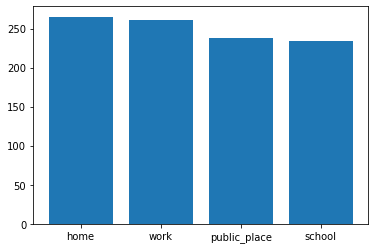

In [3]:
loc_counts = modeledWorld1.plot_location_type_distribution()
print(loc_counts)

In [4]:
print('Number of agents:'+ str(len(modeledWorld1.people)))

Number of agents:825


In [5]:
start = timeit.default_timer()
simulation1 = Simulation(modeledWorld1,200)
stop = timeit.default_timer()
print('required time: ', stop - start)  

required time:  3.273754039999999


In [6]:
df  = simulation1.simulation_timecourse

In [12]:
loc_stat=simulation1.get_location_and_status()
print(loc_stat.head())gi

status  loc  time    D    I    R    S
0         4     1  0.0  0.0  0.0  6.0
1         4     2  0.0  0.0  0.0  6.0
2         4     3  0.0  0.0  0.0  6.0
3         4     4  0.0  0.0  0.0  6.0
4         4     5  0.0  0.0  0.0  6.0
316.0


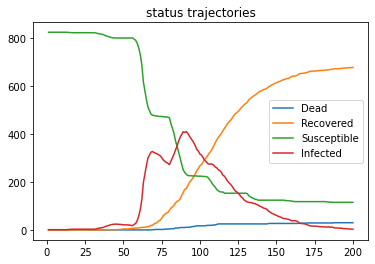

In [8]:
simulation1.plot_status_timecourse()


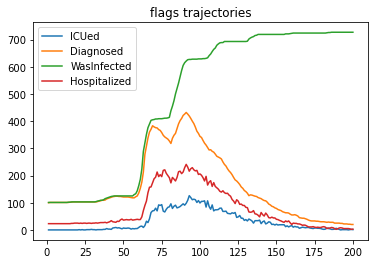

In [9]:
simulation1.plot_flags_timecourse()


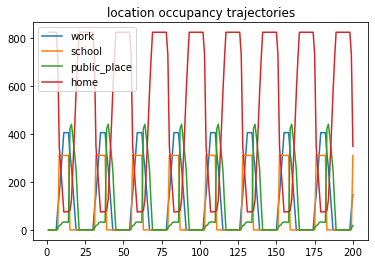

In [10]:
simulation1.plot_location_type_occupancy_timecourse()

In [11]:
simulation1.export_time_courses_as_csvs(identifier='testing') 
# Exports the CSVs to the outputs folder.
# Files marked with the identifier 'testing' get automatically deleted by the testrunner.
# Use a different identifier name if you want your outputs to remain in the folder.
